The database is composed by several CSV (Comma-Separated Values) files, each one with 8 columns, one column for each sensor, according to:

column 1 tachometer signal that allows to estimate rotation frequency;

columns 2 to 4 underhang bearing accelerometer (axial, radiale tangential direction);

columns 5 to 7 overhang bearing accelerometer (axial, radiale tangential direction);

column 8 microphone.

source: https://www02.smt.ufrj.br/~offshore/mfs/page_01.html

According to the description of the columns there are not one two radial orthogonal accelerometers. Thus, it is not possible to observe the movement orbit of the rotating machine.

On the other hand, perhaps the tangential accelerometer is also moving radially, therefore orthogonal to the radial accelerometer.

Soft-DTW é uma função de perda diferenciável usada em análise de séries temporais, baseada no Dynamic Time Warping (DTW). Permite comparar séries de tamanhos variáveis, é robusta a deslocamentos e dilatações no tempo, e pode ser usada em aprendizado de máquina para tarefas como média, clustering e previsão.


- Instalação do soft-DTW:

1 - activate a venv
2 - pip install --upgrade pip setuptools wheel
3 - pip install numpy cython
4 - pip install soft-dtw

In [ ]:
# pip install soft-dtw

In [70]:
pip show soft-dtw

Name: soft-dtw
Version: 0.1.6
Summary: Python implementation of soft-DTW
Home-page: https://github.com/mblondel/soft-dtw/
Author: 
Author-email: 
License: Simplified BSD
Location: d:\IFSP\Matematica - Aulas\Math_Codes\math\Lib\site-packages
Requires: chainer, cython, numpy, scikit-learn, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [72]:
import os
import numpy as np
import pandas as pd
# import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from tensorflow.keras import layers, models
# from tensorflow.keras.utils import plot_model
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.fft import rfft, rfftfreq
from scipy import integrate

#### 1 - Carregando df_normal

In [73]:
# df_20g = "C:/Files/mafaulda_full/overhang/ball_fault/20g"
df_normal = "C:/Files/mafaulda_full/normal"
# df_unbalance_20g = "C:/Files/mafaulda_bas/imbal_small/20g"


#### 1.1 - Concatenação:

In [74]:
# Lista para armazenar os DataFrames

dataframes = []

# Verifica se o caminho fornecido é um diretório válido
if os.path.isdir(df_normal):
    # Iterar pelos arquivos no diretório
    for filename in os.listdir(df_normal):
        if filename.endswith(".csv"): 
            file_path = os.path.join(df_normal, filename)
            
            try:
                # Lendo o arquivo CSV, pulando a primeira linha (cabeçalho).
                # O parâmetro skiprows=1 é a chave para resolver o problema do 'object' dtype.
                df = pd.read_csv(file_path, sep=',', header=None, skiprows=1)
                dataframes.append(df)
            except Exception as e:
                print(f"Não foi possível ler o arquivo {filename}: {e}")


    if dataframes:
        #Concatenando os dataframes em um único:
        df_normal_concat = pd.concat(dataframes, ignore_index=True)

        # Mostrando as primeiras linhas e tipos de dados:
        print("__Dataframe combinado (df_normal) ___")
        print(df_normal_concat.head())
        print("\n--- Tipos de dados (dtypes) ---")
        print(df_normal_concat.dtypes)
    else:
        print("Não houve leitura de arquivos")
else:
    print(f"diretório df_normal não encontrado: {df_normal}")


__Dataframe combinado (df_normal) ___
        0         1         2         3        4         5        6         7
0  4.6038 -0.051295 -0.194050 -0.060071 -0.41809  0.036547 -0.11043  0.118310
1  4.5703 -0.969080  0.038033 -0.028329 -0.43081  0.041924 -0.14331 -0.071527
2  4.5870  0.891270  0.072973  0.007453 -0.40017  0.041090 -0.11984  0.043445
3  4.5887 -1.716000 -0.329290 -0.033063 -0.50281  0.040474 -0.25270  0.023901
4  4.5675  1.240300  0.354010  0.040460 -0.36806  0.044062 -0.14258 -0.054880

--- Tipos de dados (dtypes) ---
0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
7    float64
dtype: object


- Supondo ultima coluna como rotulos ou classes (y) e as demais como features (X):

In [75]:

X = df_normal_concat.iloc[:, :].values         # Todas as colunas, menos a última
#y = df_normal_concat.iloc[:, -1]         # Apenas a última coluna
y = np.full(X.shape[0], 1)  # Criando um array de rótulos com valor 1 para todas as amostras


In [76]:
print("--- Verificação de X e y ---")
# Para NumPy arrays, usamos fatiamento para ver o "cabeçalho" e .dtype para o tipo de dado
print("X head:\n", X[:4]) # Mostra as primeiras 5 linhas (fatiamento de array)
print("\nX numpy dtype:", X.dtype) # Mostra o tipo de dado do array NumPy
print("\ny head:\n", y[:4]) # Mostra as primeiras 5 linhas de y
print("\ny dtypes:", y.dtype) # Mostra o tipo de dado do array NumPy
print('--------------------------------------')
print("X shape:", X.shape)
print("y shape:", y.shape)
print('--------------------------------------')
print('ooooooooooooooooooooooooooooooooooooo')


--- Verificação de X e y ---
X head:
 [[ 4.6038    -0.051295  -0.19405   -0.060071  -0.41809    0.036547
  -0.11043    0.11831  ]
 [ 4.5703    -0.96908    0.038033  -0.028329  -0.43081    0.041924
  -0.14331   -0.071527 ]
 [ 4.587      0.89127    0.072973   0.0074526 -0.40017    0.04109
  -0.11984    0.043445 ]
 [ 4.5887    -1.716     -0.32929   -0.033063  -0.50281    0.040474
  -0.2527     0.023901 ]]

X numpy dtype: float64

y head:
 [1 1 1 1]

y dtypes: int64
--------------------------------------
X shape: (12249951, 8)
y shape: (12249951,)
--------------------------------------
ooooooooooooooooooooooooooooooooooooo


#### 1.2 - Normalização:

- É um comportamento esperado do pandas. Essa linha não se refere a uma coluna específica do seu DataFrame. Ela descreve o tipo de dados da própria lista de tipos que está sendo exibida. Como a lista contém vários objetos de tipo float64 e outros, o pandas a classifica como uma série de tipo object.
- fit (Ajustar/Aprender): A primeira parte, fit, "olha" para cada coluna (cada sensor), calcula a média (μ) e o desvio padrão (σ) daquela coluna específica, aprendendo os parâmetros de distribuição dos dados.

In [77]:
# Função para normalizar os dados. preprocess_data padroniza os dados antes de entregá-los ao modelo para tr

print("\n1. Aplicando a normalização (StandardScaler) aos dados de X...")

def preprocess_data(data_to_scale):                                  # X  é o conjunto de dados de entrada (as leituras dos 8 sensores de vibração
    print("   'X_scaled' foi criado com sucesso!")
    scaler = StandardScaler()
    scaled_data_out = scaler.fit_transform(data_to_scale)
        
    # VISUALIZAR OS DADOS NORMALIZADOS
    print("\n2. Gerando gráficos para visualização...")
    return scaled_data_out




1. Aplicando a normalização (StandardScaler) aos dados de X...


### 1.3 - Análise do sinal do tacômetro:


1. Aplicando a normalização (StandardScaler) aos dados de X...
   'X_scaled' foi criado com sucesso!

2. Gerando gráficos para visualização...
   'X_scaled' foi criado com sucesso!
   Formato do X_scaled: (12249951, 8), Tipo: <class 'numpy.ndarray'>
-----------------------------------------

2. Gerando gráficos para visualização...


C:\Users\carlo\AppData\Local\Temp\ipykernel_16760\3513223732.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
d:\IFSP\Matematica - Aulas\Math_Codes\math\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


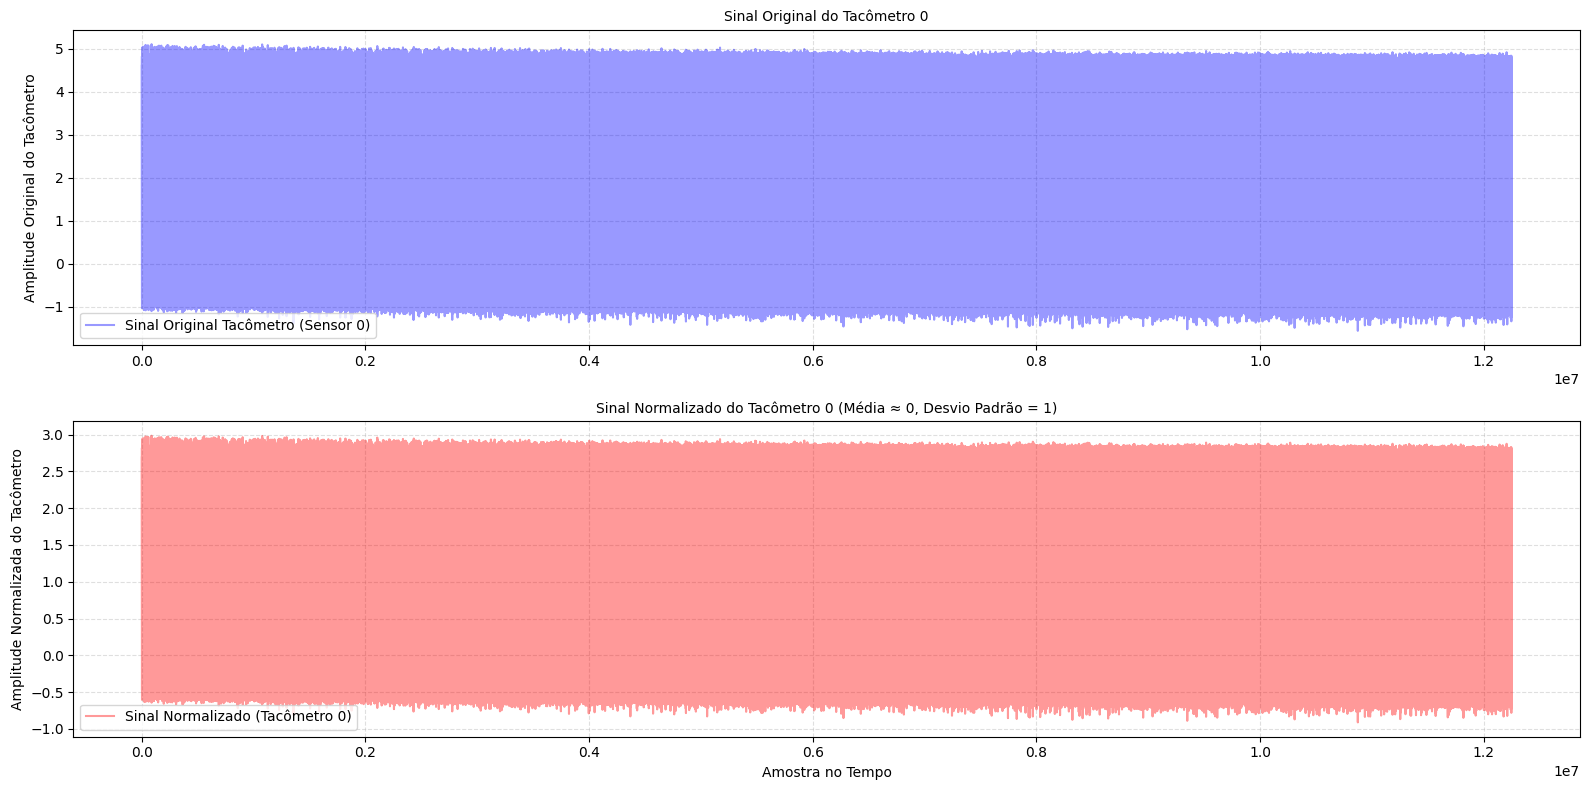

In [78]:
print("\n1. Aplicando a normalização (StandardScaler) aos dados de X...")
X_scaled = preprocess_data(X) # <--- CHAMA A FUNÇÃO E OBTÉM O RESULTADO
print("   'X_scaled' foi criado com sucesso!")
print(f"   Formato do X_scaled: {X_scaled.shape}, Tipo: {type(X_scaled)}")
print('-----------------------------------------')

# --- VISUALIZAR OS DADOS NORMALIZADOS (Plotagem) ---
print("\n2. Gerando gráficos para visualização...")

sensor_a_visualizar = 0 # Tacômetro (ou o índice da coluna do sensor que você quer plotar de X)

# Acessa os dados originais (X deve ser um array NumPy)
raw_tac_signal = X[:, sensor_a_visualizar]
# Acessa os dados já escalados
scaled_tac_signal = X_scaled[:, sensor_a_visualizar]

# --- Gráfico 1: Comparação do Sinal no Tempo ---
plt.figure(figsize=(16, 8))

# Gráfico do sinal original
plt.subplot(2, 1, 1)
plt.plot(raw_tac_signal, label=f'Sinal Original Tacômetro (Sensor {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Tacômetro {sensor_a_visualizar}', fontsize=10)
plt.ylabel('Amplitude Original do Tacômetro', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Gráfico do sinal normalizado
plt.subplot(2, 1, 2)
plt.plot(scaled_tac_signal, label=f'Sinal Normalizado (Tacômetro {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Tacômetro {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel('Amostra no Tempo', fontsize=10)
plt.ylabel('Amplitude Normalizada do Tacômetro', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

- "Contagem" significa a frequência ou o número de vezes que um determinado valor de amplitude ocorreu no seu conjunto de dados.
- A linha azul contínua (chamada de KDE - Kernel Density Estimate) é uma versão suavizada do histograma. O pico dessa linha mostra qual é o valor de amplitude mais comum em todo o conjunto de dados.

#### - Analisando o sinal não normalizado. A normalização não afeta os dados do dataset, apenas atribui uma escala proporcional de valores:


2. Gerando gráficos para visualização...


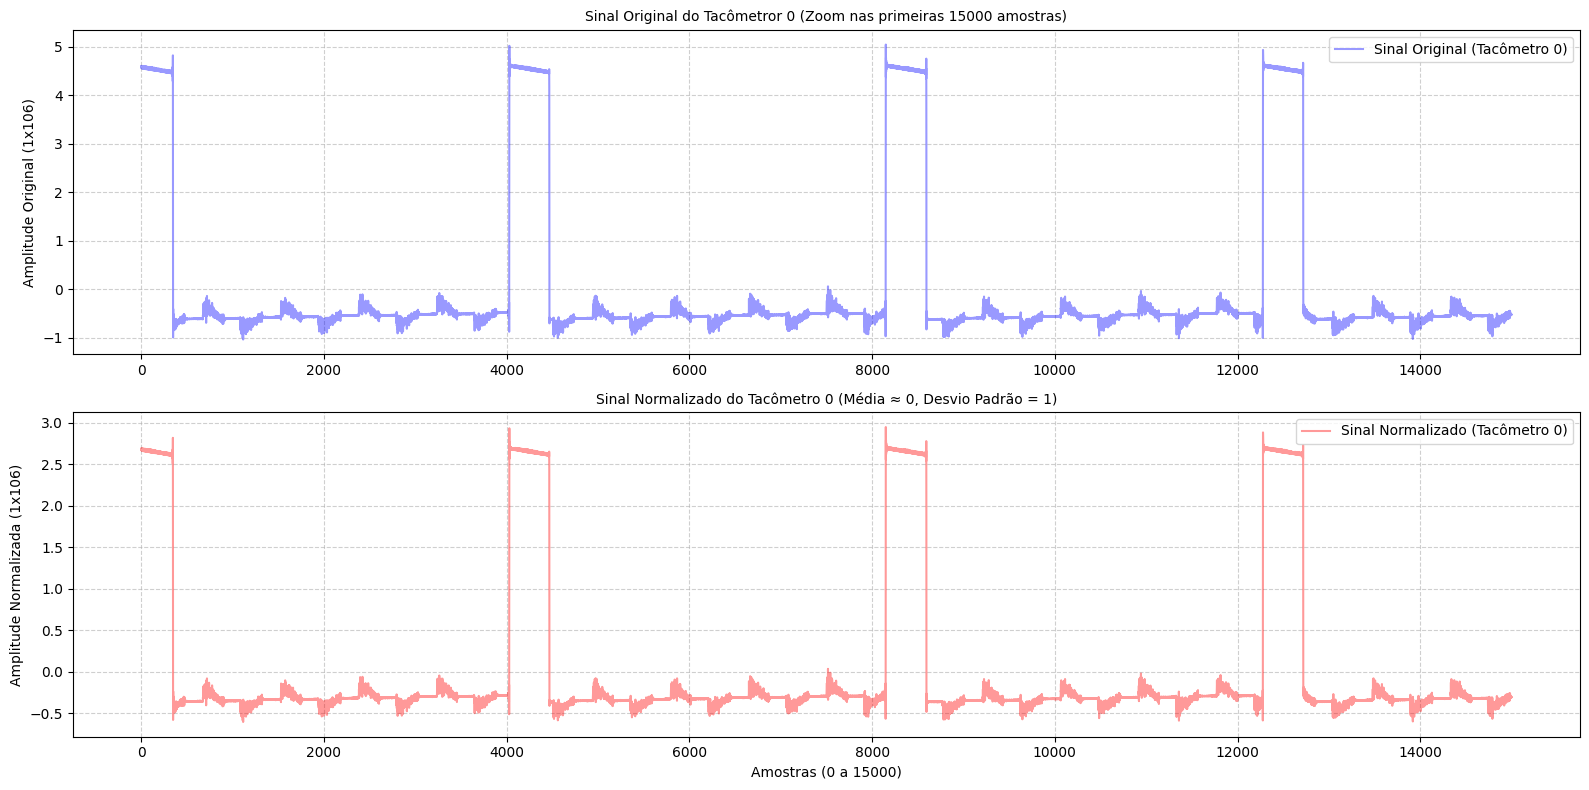

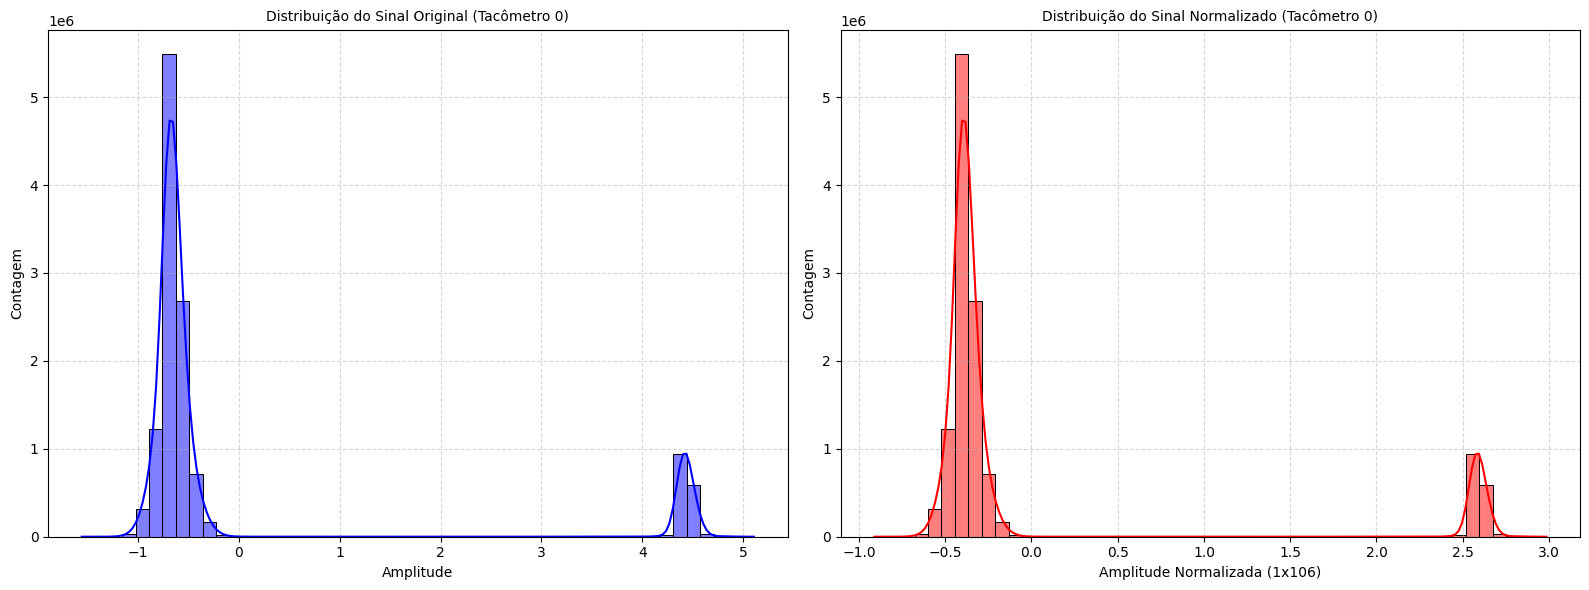


Visualização concluída.


In [79]:
# 2. VISUALIZAR OS DADOS NÃO NORMALIZADOS (COM ZOOM)
print("\n2. Gerando gráficos para visualização...")

# Escolha qual coluna do sensor (0 a 7) você quer visualizar
sensor_a_visualizar = 0 
# Define o número de amostras para o "zoom" para melhor visualização
num_amostras_plot = 15000

# Pega todos os dados da coluna do sensor escolhido. Removi o .values pois deve ser usado apenas para ler 
# os dados como um array NumPy, mas aqui estamos usando diretamente o DataFrame.
raw_tac_signal = X[:, sensor_a_visualizar]
#scaled_tac_signal = X_scaled[:, sensor_a_visualizar]

# --- Gráfico 1: Comparação do Sinal no Tempo do sinal original (com zoom) ---
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
# Plota apenas as primeiras 'num_amostras_plot' amostras para dilatar o eixo X
plt.plot(raw_tac_signal[:num_amostras_plot], label=f'Sinal Original (Tacômetro {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Tacômetror {sensor_a_visualizar} (Zoom nas primeiras {num_amostras_plot} amostras)', fontsize=10)
plt.ylabel('Amplitude Original (1x106)', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Gráfico do sinal não normalizado (zoom)
plt.subplot(2, 1, 2)
# Plota apenas as primeiras 'num_amostras_plot' amostras
plt.plot(scaled_tac_signal[:num_amostras_plot], label=f'Sinal Normalizado (Tacômetro {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Tacômetro {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel(f'Amostras (0 a {num_amostras_plot})', fontsize=10)
plt.ylabel('Amplitude Normalizada (1x106)', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# --- Gráfico 2: Comparação da Distribuição dos Dados (usando o sinal completo) ---
plt.figure(figsize=(16, 6))

# Histograma do sinal original
plt.subplot(1, 2, 1)
sns.histplot(raw_tac_signal, kde=True, color='blue', bins=50)
plt.title(f'Distribuição do Sinal Original (Tacômetro {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Amplitude', fontsize=10)
plt.ylabel('Contagem', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

# Histograma do sinal normalizado
plt.subplot(1, 2, 2)
sns.histplot(scaled_tac_signal, kde=True, color='red', bins=50)
plt.title(f'Distribuição do Sinal Normalizado (Tacômetro {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Amplitude Normalizada (1x106)', fontsize=10)
plt.ylabel('Contagem', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nVisualização concluída.")

- Análise no Domínio do Tempo (Sincronização e Visualização): Primeiro, vamos plotar o sinal de vibração do acelerômetro contra uma base de tempo real em segundos e, ao mesmo tempo, usar o tacômetro para calcular a rotação exata da máquina (RPM) naquele ensaio.
- Análise no Domínio da Frequência (objetivo): Em seguida, usaremos a Transformada Rápida de Fourier (FFT) para converter o sinal de vibração do domínio do tempo para o domínio da frequência. É aqui que a "assinatura" do desbalanceamento se tornará visível e quantificável.
- o sinal do tacômetro nos dá a base de tempo (a rotação da máquina), e o sinal do acelerômetro nos dá a vibração.

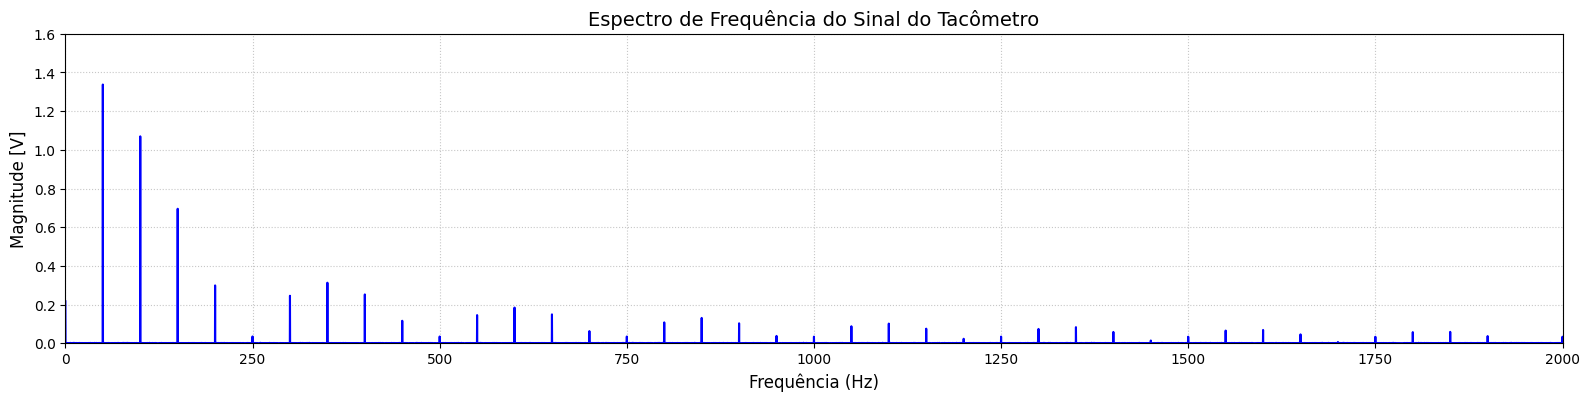

In [80]:
# a magnitude da FFT precisa ser normalizada:

SAMPLE_RATE = 50000  # Taxa de amostragem (Hz)
DURACAO_SEGUNDOS = 5  # Duração do sinal em segundos (usado para simulação)

num_samples_total = int(SAMPLE_RATE * DURACAO_SEGUNDOS)
t_full = np.linspace(0, DURACAO_SEGUNDOS, num_samples_total, endpoint=False)

# --- Criar o eixo do tempo para plotagem ---
t = np.linspace(0, DURACAO_SEGUNDOS, N, endpoint=False)

# --- CÁLCULO E PLOTAGEM DO ESPECTRO DE FREQUÊNCIA (Gráfico Inferior) ---

# 1. Calcular a Transformada Rápida de Fourier Real (RFFT)
fft_values = rfft(raw_tac_signal_1d)

# 2. Calcular as frequências correspondentes aos valores da FFT
frequencies = rfftfreq(N, 1.0 / SAMPLE_RATE)

# 3. Calcular a Magnitude (Amplitude) do Espectro e NORMALIZAR
# A correção é aqui: dividir por N/2 para obter a amplitude dos picos
magnitudes = np.abs(fft_values) * 2 / N
# Para a componente DC (Frequência 0 Hz), não multiplicamos por 2
magnitudes[0] = np.abs(fft_values[0]) / N # ou simplesmente magnitudes[0] = magnitudes[0] / 2

plt.figure(figsize=(16, 8))

# Plotar o espectro da frequência
plt.subplot(2, 1, 2)
plt.plot(frequencies, magnitudes, color='blue')
plt.title('Espectro de Frequência do Sinal do Tacômetro', fontsize=14)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Magnitude [V]', fontsize=12) # Eixo Y em Volts, como no seu exemplo
plt.grid(True, linestyle=':', alpha=0.7)
plt.xlim(0, 2000) # Limite X similar ao gráfico de exemplo
plt.ylim(0, 1.6) # Limite Y similar ao gráfico de exemplo

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [81]:
import numpy as np
import pandas as pd # Necessário se df_normal_concat é um DataFrame

# --- Parâmetros Globais Necessários ---
# Assumindo que a TAXA_AMOSTRAGEM e a duração de cada 'segmento' original
# são as mesmas que foram usadas para criar df_TAC_concat.
# Se df_normal_concat representa 5 segundos * 49 arquivos = 245 segundos no total,
# então num_samples_total / SAMPLE_RATE deveria dar 245 segundos.
TAXA_AMOSTRAGEM = 50000 # Hz (50 kHz) - Conforme seus documentos 

# DEFINIÇÃO DOS ÍNDICES DAS COLUNAS
COLUNA_TACOMETRO = 0 # Coluna do tacômetro é a primeira (índice 0) 

# Limiar para detecção de pulso do tacômetro
limiar_pulso = 2.5 # Valor comum para sinais que alternam entre baixo e alto 

# --- Entrada de dados: o DataFrame concatenado ---
# ATENÇÃO: VOCÊ DEVE GARANTIR QUE 'df_normal_concat' ESTEJA DEFINIDO ANTES DESTE CÓDIGO.
# Se df_normal_concat não for definido ANTES, este código NÃO SERÁ EXECUTÁVEL.
# Exemplo de como df_normal_concat DEVERIA ter sido criado (remova se já o tem):
# from your_module import carregar_dados_mafaulda # Se você tem sua função de carregamento
# df_normal_concat = carregar_dados_mafaulda("C:/Files/mafaulda_bas/imbal_small/20g", label=1) # Exemplo

# Verificação para garantir que df_normal_concat está disponível
if 'df_normal_concat' not in locals() and 'df_normal_concat' not in globals():
    print("ERRO: 'df_normal_concat' não está definido. Por favor, carregue seu DataFrame concatenado antes de executar este código.")
    # Adicionar aqui um placeholder ou exit, caso não queira que o script continue
    exit() # Ou raise SystemExit("...")

print(f"\n--- Calculando RPMs para o DataFrame concatenado ---")

# Extrai o sinal do tacômetro da coluna especificada de df_normal_concat
# Garante que seja um array NumPy 1D
sinal_tacometro_concat = df_normal_concat.values[:, COLUNA_TACOMETRO].flatten()

# Calcula a Duração Total do Sinal em Segundos do DataFrame concatenado
duracao_sinal_s_total = len(sinal_tacometro_concat) / TAXA_AMOSTRAGEM

# Identificar Pulsos do Tacômetro no sinal total
# np.where retorna os índices onde a condição é verdadeira.
indices_pulsos_total = np.where((sinal_tacometro_concat[:-1] < limiar_pulso) & (sinal_tacometro_concat[1:] >= limiar_pulso))[0]
num_pulsos_total = len(indices_pulsos_total)

# 6. Calcular RPM médio do sinal concatenado
if duracao_sinal_s_total > 0:
    rpm_calculado_total = (num_pulsos_total / duracao_sinal_s_total) * 60
    print(f"\nVelocidade Média de Rotação da Máquina (Sinal Total): {rpm_calculado_total:.2f} RPM")
else:
    rpm_calculado_total = 0
    print("AVISO: Duração total do sinal de tacômetro é zero ou inválida. Não foi possível calcular o RPM médio.")

frequencia_rotacao_hz_total = rpm_calculado_total / 60
print(f"Frequência Média de Rotação (f1 - Sinal Total): {frequencia_rotacao_hz_total:.2f} Hz")

print("\n--- CÁLCULO DE RPM BASEADO NO DATAFRAME CONCATENADO CONCLUÍDO ---")

# --- Para calcular Mínimo e Máximo de RPM se cada 'ensaio' original tivesse seu próprio RPM ---
# Isso é mais complexo porque você precisa saber a duração de cada ensaio dentro do concatenado.
# Se cada arquivo original tinha, por exemplo, 5 segundos de duração,
# você pode segmentar o sinal concatenado de volta em "ensaios" e calcular.

# Assumindo que cada 'ensaio' original tinha 5 segundos de duração (DURACAO_ENSAIO_S = 5)
# e TAXA_AMOSTRAGEM = 50000 Hz, então cada ensaio tem 250000 amostras.
AMOSTRAS_POR_ENSAIO = int(DURACAO_ENSAIO_S * TAXA_AMOSTRAGEM)

if num_pulsos_total > 0 and AMOSTRAS_POR_ENSAIO > 0:
    num_ensaios = len(sinal_tacometro_concat) // AMOSTRAS_POR_ENSAIO
    rpms_por_ensaio = []

    print(f"\n--- Calculando RPMs para cada segmento de {DURACAO_ENSAIO_S} segundos ---")
    for i in range(num_ensaios):
        start_idx = i * AMOSTRAS_POR_ENSAIO
        end_idx = (i + 1) * AMOSTRAS_POR_ENSAIO
        
        sinal_ensaio = sinal_tacometro_concat[start_idx:end_idx]

        if len(sinal_ensaio) > 0: # Garante que o segmento não está vazio
            indices_pulsos_ensaio = np.where((sinal_ensaio[:-1] < limiar_pulso) & (sinal_ensaio[1:] >= limiar_pulso))[0]
            num_pulsos_ensaio = len(indices_pulsos_ensaio)
            
            # Use a duração nominal do ensaio (5 segundos) para o cálculo do RPM deste ensaio
            rpm_ensaio = (num_pulsos_ensaio / DURACAO_ENSAIO_S) * 60
            rpms_por_ensaio.append(rpm_ensaio)
            # print(f" -> Segmento {i+1}, RPM Calculado: {rpm_ensaio:.2f}") # Opcional: imprimir cada um

    if rpms_por_ensaio:
        min_rpm_segmentos = np.min(rpms_por_ensaio)
        max_rpm_segmentos = np.max(rpms_por_ensaio)
        mean_rpm_segmentos = np.mean(rpms_por_ensaio)

        print(f"\n--- Estatísticas de RPM por segmento ({DURACAO_ENSAIO_S}s cada) ---")
        print(f"Total de segmentos analisados: {len(rpms_por_ensaio)}")
        print(f"Velocidade Média por segmento: {mean_rpm_segmentos:.2f} RPM")
        print(f"Velocidade Mínima por segmento: {min_rpm_segmentos:.2f} RPM")
        print(f"Velocidade Máxima por segmento: {max_rpm_segmentos:.2f} RPM")
    else:
        print("\nAVISO: Não foi possível calcular RPMs por segmento. Verifique os parâmetros de segmentação.")
else:
    print("\nAVISO: Não há pulsos detectados no sinal total ou amostras por ensaio inválidas. Não é possível calcular RPMs por segmento.")

print("\n--- Análise Completa de Velocidade Concluída ---")


--- Calculando RPMs para o DataFrame concatenado ---

Velocidade Média de Rotação da Máquina (Sinal Total): 2156.82 RPM
Frequência Média de Rotação (f1 - Sinal Total): 35.95 Hz

--- CÁLCULO DE RPM BASEADO NO DATAFRAME CONCATENADO CONCLUÍDO ---

--- Calculando RPMs para cada segmento de 5 segundos ---

--- Estatísticas de RPM por segmento (5s cada) ---
Total de segmentos analisados: 48
Velocidade Média por segmento: 2126.75 RPM
Velocidade Mínima por segmento: 720.00 RPM
Velocidade Máxima por segmento: 3540.00 RPM

--- Análise Completa de Velocidade Concluída ---
